In [1]:
import json
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wczytywanie konfiguracji
config_path = Path("../config.json")
with open(config_path, "r") as config_file:
    config = json.load(config_file)

# Ścieżki z konfiguracji
model_file = Path(config["resnet50_masterCategory_model"])
test_file = Path(config["train_file"])
dataset_path = Path(config["dataset_path"])

print(f"Ścieżki załadowane:\nModel: {model_file}\nTest File: {test_file}\nDataset Path: {dataset_path}")


2024-11-30 00:18:16.379233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 00:18:16.396696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 00:18:16.401923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Ścieżki załadowane:
Model: /home/ubuntu/fashion/fashion/models/resnet50_masterCategory_model.h5
Test File: /home/ubuntu/fashion/fashion/data/styles_train.csv
Dataset Path: /home/ubuntu/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1


In [2]:
# Wczytanie testowych danych
df_test = pd.read_csv(test_file)

# Tworzenie pełnych ścieżek do obrazów
df_test["image_path"] = df_test["id"].apply(lambda x: dataset_path / "images" / f"{x}.jpg")
df_test = df_test[df_test["image_path"].apply(lambda path: Path(path).exists())]

# Przygotowanie etykiet
categories = df_test["masterCategory"].unique()
category_to_index = {category: idx for idx, category in enumerate(categories)}
index_to_category = {idx: category for category, idx in category_to_index.items()}
df_test["category_index"] = df_test["masterCategory"].map(category_to_index)

print("Pierwsze wiersze danych testowych:")
print(df_test.head())


Pierwsze wiersze danych testowych:
      id gender masterCategory subCategory   articleType baseColour  season  \
0  17848  women        apparel     topwear       tshirts      white    fall   
1  44045    men  personal care   fragrance         other        red  spring   
2   4006    men       footwear  flip flops    flip flops      black  summer   
3  49978    men        apparel   innerwear         other  navy blue  summer   
4  36220  women       footwear       shoes  sports shoes       blue  summer   

     year   usage                                 productDisplayName  \
0  2011.0  casual        flying machine women mind your white tshirt   
1  2017.0  casual                          hugo men energise perfume   
2  2011.0  casual  spalding men's black yellow with graphic flip ...   
3  2016.0  casual                 hanes men navy blue innerwear vest   
4  2012.0  sports      nike women dual fusion st 2 blue sports shoes   

                                          image_path  cat

In [3]:
# Ustawienia dla generatora danych
image_size = (224, 224)  # Rozmiar obrazu zgodny z modelem
batch_size = 32

# Funkcja pomocnicza do wczytywania i przetwarzania obrazów
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalizacja
    return image, label

# Konwersja do TensorFlow Dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test["image_path"].astype(str), df_test["category_index"])
)
test_ds = test_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1732925900.158120   74358 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732925900.210858   74358 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732925900.214216   74358 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732925900.218601   74358 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
# Wczytanie modelu
resnet50_masterCategory_model = tf.keras.models.load_model(model_file)
resnet50_masterCategory_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,800 (91.99 MB)

 Trainable params: 4,991,750 (19.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

In [5]:
# Ewaluacja modelu na zbiorze testowym
loss, accuracy = resnet50_masterCategory_model.evaluate(test_ds, verbose=1)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


I0000 00:00:1732925905.604366   74461 service.cc:146] XLA service 0x742914049f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732925905.604396   74461 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-30 00:18:25.704666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 00:18:26.114691: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90400
2024-11-30 00:18:26.508128: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1380', 4 bytes spill stores, 4 bytes spill loads

2024-11-30 00:18:26.781426: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 

  16/1101 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9261 - loss: 0.2161

I0000 00:00:1732925909.212453   74461 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1098/1101 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9100 - loss: 0.3218

2024-11-30 00:18:41.870922: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1387', 4 bytes spill stores, 4 bytes spill loads



1101/1101 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9100 - loss: 0.3218
Loss: 0.3196, Accuracy: 0.9107


In [6]:
# Predykcja na danych testowych
predictions = []
true_labels = []
for images, labels in test_ds:
    preds = resnet50_masterCategory_model.predict(images, verbose=0)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

# Konwersja indeksów na kategorie
predicted_categories = [index_to_category[idx] for idx in predictions]
true_categories = [index_to_category[idx] for idx in true_labels]

# Dodanie predykcji do DataFrame
df_test["predicted_category"] = predicted_categories

# Pierwsze wiersze z wynikami
print(df_test[["masterCategory", "predicted_category"]].head())


  masterCategory predicted_category
0        apparel            apparel
1  personal care            apparel
2       footwear           footwear
3        apparel            apparel
4       footwear           footwear


2024-11-30 00:19:57.197122: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 720x576 with 0 Axes>

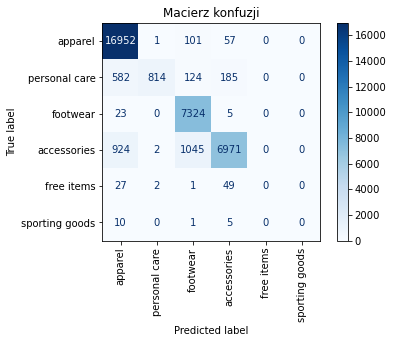

In [7]:
# Macierz konfuzji
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_categories, predicted_categories, labels=categories)

# Wyświetlenie macierzy
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Macierz konfuzji")
plt.show()


In [8]:
from sklearn.metrics import confusion_matrix

# Obliczenie macierzy konfuzji
cm = confusion_matrix(true_categories, predicted_categories, labels=categories)

# Wyświetlenie macierzy w postaci tekstowej
print("Macierz konfuzji (tekstowa):\n")
print("Categories:", categories)
print(cm)


Macierz konfuzji (tekstowa):

Categories: ['apparel' 'personal care' 'footwear' 'accessories' 'free items'
 'sporting goods']
[[16952     1   101    57     0     0]
 [  582   814   124   185     0     0]
 [   23     0  7324     5     0     0]
 [  924     2  1045  6971     0     0]
 [   27     2     1    49     0     0]
 [   10     0     1     5     0     0]]


Przykłady błędnych klasyfikacji:
                                           image_path masterCategory  \
1   /home/ubuntu/.cache/kagglehub/datasets/paramag...  personal care   
6   /home/ubuntu/.cache/kagglehub/datasets/paramag...    accessories   
10  /home/ubuntu/.cache/kagglehub/datasets/paramag...    accessories   
26  /home/ubuntu/.cache/kagglehub/datasets/paramag...    accessories   
45  /home/ubuntu/.cache/kagglehub/datasets/paramag...        apparel   

   predicted_category  
1             apparel  
6            footwear  
10           footwear  
26            apparel  
45           footwear  


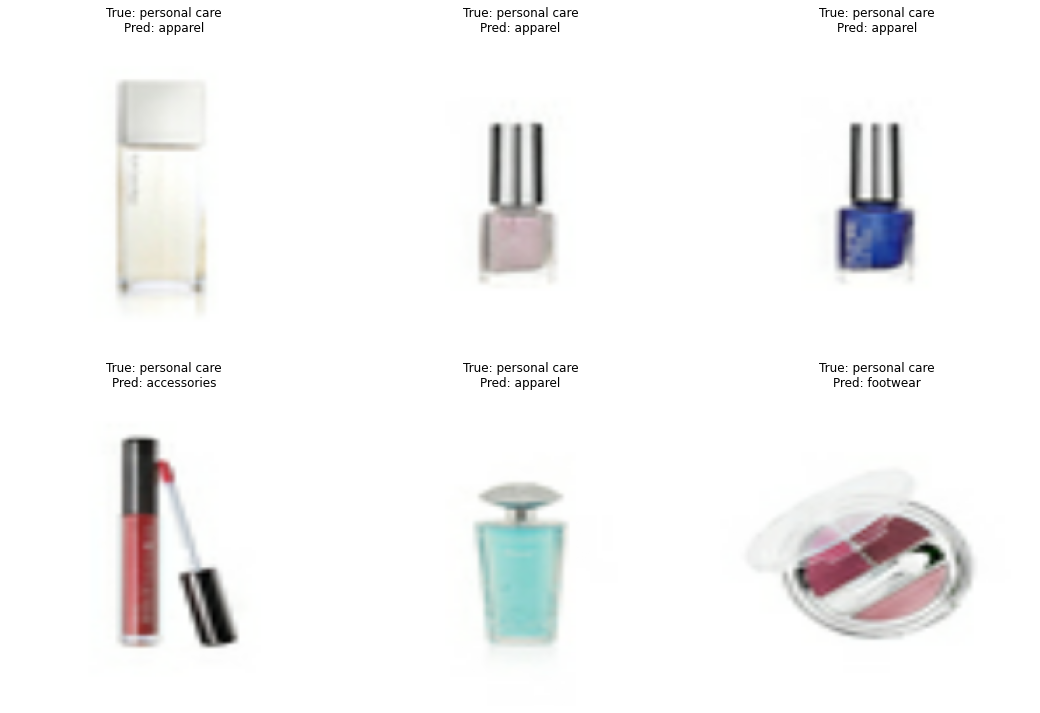

In [9]:
# Błędne klasyfikacje
df_test["is_correct"] = df_test["masterCategory"] == df_test["predicted_category"]
incorrect = df_test[~df_test["is_correct"]]

# Wyświetlenie kilku przykładów błędnych klasyfikacji
print("Przykłady błędnych klasyfikacji:")
print(incorrect[["image_path", "masterCategory", "predicted_category"]].head())

# Wizualizacja kilku obrazów błędnie sklasyfikowanych
plt.figure(figsize=(15, 10))
for i, row in enumerate(incorrect.sample(6).itertuples()):
    # Konwersja ścieżki na string
    img_path = str(row.image_path)
    
    # Wczytanie i przetwarzanie obrazu
    img = tf.image.decode_jpeg(tf.io.read_file(img_path))
    img = tf.image.resize(img, image_size)
    
    # Wyświetlenie obrazu
    plt.subplot(2, 3, i + 1)
    plt.imshow(img / 255.0)
    plt.title(f"True: {row.masterCategory}\nPred: {row.predicted_category}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
# Obliczenie metryk
from sklearn.metrics import classification_report

report = classification_report(true_categories, predicted_categories, target_names=categories)
print("Raport klasyfikacji:")
print(report)


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Raport klasyfikacji:
                precision    recall  f1-score   support

       apparel       0.96      0.78      0.86      8942
 personal care       0.92      0.99      0.95     17111
      footwear       0.85      1.00      0.92      7352
   accessories       0.00      0.00      0.00        79
    free items       0.99      0.48      0.65      1705
sporting goods       0.00      0.00      0.00        16

      accuracy                           0.91     35205
     macro avg       0.62      0.54      0.56     35205
  weighted avg       0.91      0.91      0.90     35205

